# Data Processing

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('./processed_data/samples.csv')

In [3]:
X = df.drop(columns=['has_long_pol']).values
y = df['has_long_pol'].values

In [4]:
folder = StratifiedKFold(n_splits=5)

In [5]:
split_data = [(train_idx, test_idx) for train_idx, test_idx in folder.split(X, y)]

# Training

In [6]:
import os

from src.analysis import results_dict, model_analysis
from src.utils import pkl_save_obj

In [7]:
def file_name(name):
    return os.path.join('.', 'results', name + '.pkl')

## $\Delta\phi_{jj}$

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
df.columns[1]

'delta_phi.jj'

In [10]:
dphi_results = results_dict()
for i in range(folder.get_n_splits()):
    tr_idx, te_idx = split_data[i]
    clf_dphi = LogisticRegression(solver='lbfgs')
    model_analysis(clf_dphi, dphi_results, X[:, 1].reshape(-1, 1), y, tr_idx, te_idx)
pkl_save_obj(dphi_results, file_name('dphi_results'))

## $p_T^{\ell 1}$

In [11]:
df.columns[-5]

'pt.l1'

In [12]:
ptl1_results = results_dict()
for i in range(folder.get_n_splits()):
    tr_idx, te_idx = split_data[i]
    clf_ptl1 = LogisticRegression(solver='lbfgs')
    model_analysis(clf_ptl1, ptl1_results, X[:, -5].reshape(-1, 1), y, tr_idx, te_idx)
pkl_save_obj(ptl1_results, file_name('ptl1_results'))

## LightGBM

In [13]:
from lightgbm import LGBMClassifier

/Users/christopherwmurphy/venvs/ml4phys/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [14]:
lgbm_results = results_dict()
for i in range(folder.get_n_splits()):
    tr_idx, te_idx = split_data[i]
    clf_lgbm = LGBMClassifier(n_estimators=1000, learning_rate=0.01)
    model_analysis(clf_lgbm, lgbm_results, X, y, tr_idx, te_idx)
pkl_save_obj(lgbm_results, file_name('lgbm_results'))

## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rfc_results = results_dict()
for i in range(folder.get_n_splits()):
    tr_idx, te_idx = split_data[i]
    clf_rf = RandomForestClassifier(n_estimators=10, max_depth=10, warm_start=True)
    model_analysis(clf_rf, rfc_results, X, y, tr_idx, te_idx, early_stopping=True)
pkl_save_obj(rfc_results, file_name('rfc_results'))

## Weighted Random Forest

In [17]:
wrfc_results = results_dict()
for i in range(folder.get_n_splits()):
    tr_idx, te_idx = split_data[i]
    clf_wrf = RandomForestClassifier(n_estimators=10, max_depth=10, warm_start=True, class_weight={0: 1, 1: 3})
    model_analysis(clf_wrf, wrfc_results, X, y, tr_idx, te_idx, early_stopping=True)
pkl_save_obj(wrfc_results, file_name('wrfc_results'))

## Balanced Random Forest

In [18]:
from imblearn.ensemble import BalancedRandomForestClassifier

Using TensorFlow backend.


In [19]:
brfc_results = results_dict()
for i in range(folder.get_n_splits()):
    tr_idx, te_idx = split_data[i]
    clf_brf = BalancedRandomForestClassifier(n_estimators=10, warm_start=True)
    model_analysis(clf_brf, brfc_results, X, y, tr_idx, te_idx, early_stopping=True)
pkl_save_obj(brfc_results, file_name('brfc_results'))

## Deep Neural Network

In [20]:
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

from src.keras_model import build_model

In [21]:
fit_args = {'epochs': 100, 'batch_size': 50, 'verbose': 0, 'callbacks': [EarlyStopping(monitor='loss', patience=5)]}

In [22]:
scaler_dnn = StandardScaler()
X_dnn = scaler_dnn.fit_transform(X)
dnn_results = results_dict()
for i in range(folder.get_n_splits()):
    tr_idx, te_idx = split_data[i]
    clf_dnn = build_model(X_dnn.shape[1])
    model_analysis(clf_dnn, dnn_results, X_dnn, y, tr_idx, te_idx, **fit_args)
pkl_save_obj(dnn_results, file_name('dnn_results'))

## DNN w/ Focal Loss

In [23]:
from src.focal_loss import focal_loss

In [24]:
flnn_results = results_dict()
for i in range(folder.get_n_splits()):
    tr_idx, te_idx = split_data[i]
    clf_fl = build_model(X_dnn.shape[1], loss_function=focal_loss())
    model_analysis(clf_fl, flnn_results, X_dnn, y, tr_idx, te_idx, **fit_args)
pkl_save_obj(flnn_results, file_name('flnn_results'))

# Results

## Load Results

In [25]:
from src.utils import pkl_load_obj

In [26]:
models = [
    'Balanced RF', 
    'Deep Neural Network', 
    '$\Delta\phi_{jj}$', 
    'DNN w/ Focal Loss', 
    'LightGBM', 
    '$p_T^{\ell 1}$', 
    'Random Forest', 
    'Weighted RF'
]

In [27]:
all_files = os.listdir('./results')
all_pickles = [a_pickle for a_pickle in all_files if a_pickle.endswith('.pkl')]
all_pickles.sort()

In [28]:
results = dict()
for idx, a_pickle in enumerate(all_pickles):
    results[models[idx]] = pkl_load_obj(os.path.join('.', 'results', a_pickle))

## Show Results

### Fit Time

In [29]:
for model in models:
    print('%s: (%0.1f +/- %0.1f)s' %(model, 
                                     np.mean(results[model]['fit_time']), 
                                     np.std(results[model]['fit_time'])))

Balanced RF: (62.6 +/- 18.5)s
Deep Neural Network: (281.6 +/- 26.7)s
$\Delta\phi_{jj}$: (0.1 +/- 0.0)s
DNN w/ Focal Loss: (332.9 +/- 109.4)s
LightGBM: (9.7 +/- 0.7)s
$p_T^{\ell 1}$: (0.1 +/- 0.0)s
Random Forest: (83.8 +/- 24.1)s
Weighted RF: (30.3 +/- 15.0)s


### ROC AUC

In [30]:
for model in models:
    print('%s: (%0.3f +/- %0.3f)' %(model, 
                                    np.mean(results[model]['test_roc_auc']), 
                                    np.std(results[model]['test_roc_auc'])))

Balanced RF: (0.776 +/- 0.005)
Deep Neural Network: (0.789 +/- 0.004)
$\Delta\phi_{jj}$: (0.662 +/- 0.006)
DNN w/ Focal Loss: (0.791 +/- 0.005)
LightGBM: (0.782 +/- 0.005)
$p_T^{\ell 1}$: (0.663 +/- 0.006)
Random Forest: (0.766 +/- 0.006)
Weighted RF: (0.768 +/- 0.006)


### Average Precision

In [31]:
for model in models:
    print('%s: (%0.3f +/- %0.3f)' %(model, 
                                    np.mean(results[model]['test_average_precision']), 
                                    np.std(results[model]['test_average_precision'])))

Balanced RF: (0.228 +/- 0.007)
Deep Neural Network: (0.244 +/- 0.008)
$\Delta\phi_{jj}$: (0.120 +/- 0.003)
DNN w/ Focal Loss: (0.246 +/- 0.004)
LightGBM: (0.241 +/- 0.005)
$p_T^{\ell 1}$: (0.112 +/- 0.002)
Random Forest: (0.223 +/- 0.006)
Weighted RF: (0.227 +/- 0.006)


# Plotting

In [32]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [33]:
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.serif'] = "cm"

## Precision-Recall Curve

In [34]:
from sklearn.metrics import precision_recall_curve

In [36]:
fl_pre, fl_rec, fl_thr = precision_recall_curve(y[te_idx], clf_fl.predict_proba(X_dnn[te_idx]))
dnn_pre, dnn_rec, dnn_thr = precision_recall_curve(y[te_idx], clf_dnn.predict_proba(X_dnn[te_idx]))
brf_pre, brf_rec, brf_thr = precision_recall_curve(y[te_idx], clf_brf.predict_proba(X[te_idx]).T[1])
rf_pre, rf_rec, rf_thr = precision_recall_curve(y[te_idx], clf_rf.predict_proba(X[te_idx]).T[1])
lg_pre, lg_rec, lg_thr = precision_recall_curve(y[te_idx], clf_lgbm.predict_proba(X[te_idx]).T[1])
pt_pre, pt_rec, pt_thr = precision_recall_curve(y[te_idx], clf_ptl1.predict_proba(X[te_idx, -5].reshape(-1, 1)).T[1])

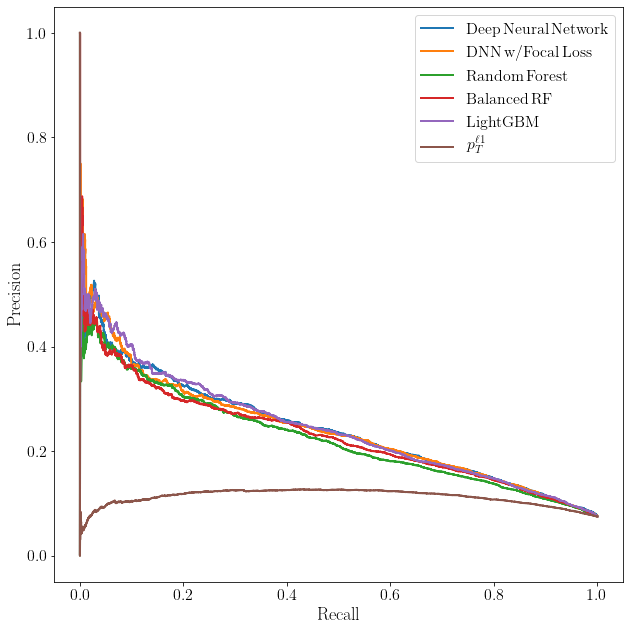

In [37]:
plt.figure(1, figsize=(9, 9))
plt.plot(dnn_rec, dnn_pre, label=r'$\rm Deep\, Neural\, Network$')
plt.plot(fl_rec, fl_pre, label=r'$\rm DNN\, w/ Focal\, Loss$')
plt.plot(rf_rec, rf_pre, label=r'$\rm Random\, Forest$')
plt.plot(brf_rec, brf_pre, label=r'$\rm Balanced\, RF$')
plt.plot(lg_rec, lg_pre, label=r'$\rm LightGBM$')
plt.plot(pt_rec, pt_pre, label=r'$p_T^{\ell 1}$')
plt.xlabel(r'$\rm Recall$')
plt.ylabel(r'$\rm Precision$')
plt.legend(loc=1)
plt.tight_layout(True)
plt.savefig('/Users/christopherwmurphy/Documents/Research/NNtest/paper/ap.pdf')
plt.show()

## ROC Curve

In [38]:
from sklearn.metrics import roc_curve

In [39]:
fl_fpr, fl_tpr, fl_the = roc_curve(y[te_idx], clf_fl.predict_proba(X_dnn[te_idx]))
dnn_fpr, dnn_tpr, dnn_the = roc_curve(y[te_idx], clf_dnn.predict_proba(X_dnn[te_idx]))
brf_fpr, brf_tpr, brf_the = roc_curve(y[te_idx], clf_brf.predict_proba(X[te_idx]).T[1])
rf_fpr, rf_tpr, rf_the = roc_curve(y[te_idx], clf_rf.predict_proba(X[te_idx]).T[1])
lg_fpr, lg_tpr, lg_the = roc_curve(y[te_idx], clf_lgbm.predict_proba(X[te_idx]).T[1])
pt_fpr, pt_tpr, pt_the = roc_curve(y[te_idx], clf_ptl1.predict_proba(X[te_idx, -5].reshape(-1, 1)).T[1])

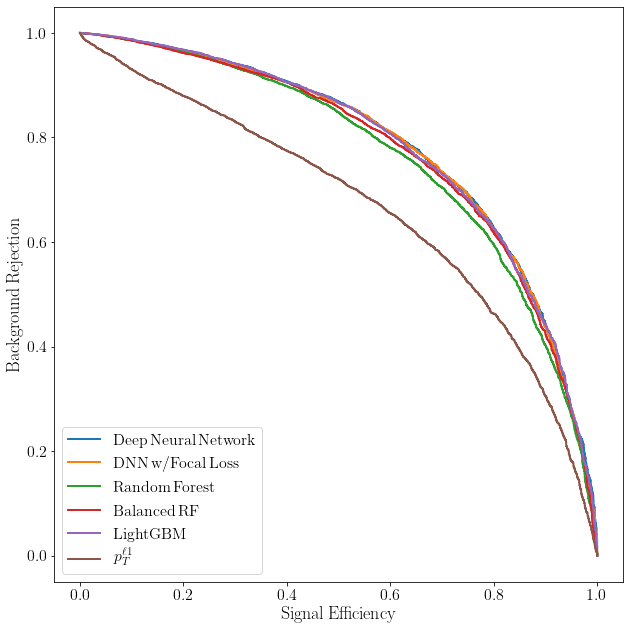

In [40]:
plt.figure(2, figsize=(9, 9))
plt.plot(dnn_tpr, 1 - dnn_fpr, label=r'$\rm Deep\, Neural\, Network$')
plt.plot(fl_tpr, 1 - fl_fpr, label=r'$\rm DNN\, w/ Focal\, Loss$')
plt.plot(rf_tpr, 1 - rf_fpr, label=r'$\rm Random\, Forest$')
plt.plot(brf_tpr, 1 - brf_fpr, label=r'$\rm Balanced\, RF$')
plt.plot(lg_tpr, 1 - lg_fpr, label=r'$\rm LightGBM$')
plt.plot(pt_tpr, 1 - pt_fpr, label=r'$p_T^{\ell 1}$')
plt.xlabel(r'$\rm Signal\, Efficiency $')
plt.ylabel(r'$\rm Background\, Rejection$')
plt.legend(loc=3)
plt.tight_layout(True)
plt.savefig('/Users/christopherwmurphy/Documents/Research/NNtest/paper/roc.pdf')
plt.show()

/Users/christopherwmurphy/venvs/ml4phys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/christopherwmurphy/venvs/ml4phys/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/christopherwmurphy/venvs/ml4phys/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/christopherwmurphy/venvs/ml4phys/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/christopherwmurphy/venvs/ml4phys/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/christopherwmurphy/venvs/ml4phys/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: di

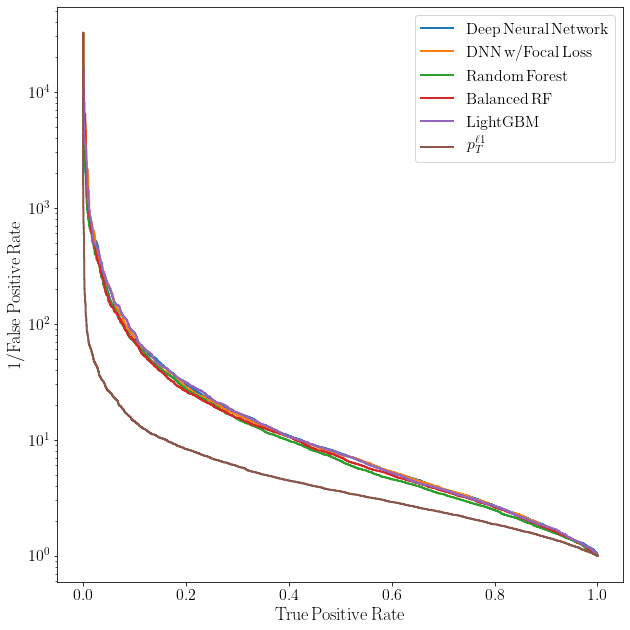

In [41]:
plt.figure(3, figsize=(9, 9))
plt.plot(dnn_tpr, 1 / dnn_fpr, label=r'$\rm Deep\, Neural\, Network$')
plt.plot(fl_tpr, 1 / fl_fpr, label=r'$\rm DNN\, w/ Focal\, Loss$')
plt.plot(rf_tpr, 1 / rf_fpr, label=r'$\rm Random\, Forest$')
plt.plot(brf_tpr, 1 / brf_fpr, label=r'$\rm Balanced\, RF$')
plt.plot(lg_tpr, 1 / lg_fpr, label=r'$\rm LightGBM$')
plt.plot(pt_tpr, 1 / pt_fpr, label=r'$p_T^{\ell 1}$')
plt.xlabel(r'$\rm True\, Positive\, Rate$')
plt.ylabel(r'$1 / \rm False\, Positive\, Rate$')
plt.yscale('log')
plt.legend(loc=1)
plt.tight_layout(True)
plt.savefig('/Users/christopherwmurphy/Documents/Research/NNtest/paper/roc_log.pdf')
plt.show()

## Kinematic Distributions

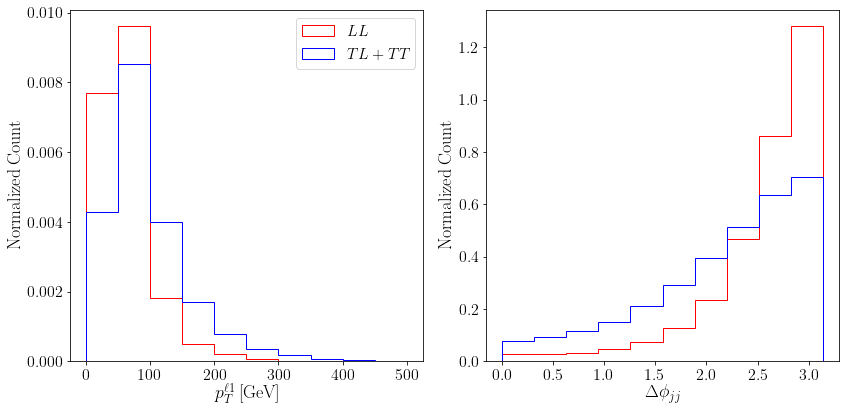

In [42]:
plt.figure(4, figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df[df['has_long_pol'] == 1]['pt.l1'], 
         bins=10, 
         range=(0, 500), 
         density=True, 
         color='r', 
         histtype='step', 
         label=r'$LL$')
plt.hist(df[df['has_long_pol'] == 0]['pt.l1'], 
         bins=10, 
         range=(0, 500), 
         density=True, 
         color='b', 
         histtype='step', 
         label=r'$TL+TT$')
plt.xlabel(r'$p_T^{\ell 1}\, \rm [GeV]$')
plt.ylabel(r'$\rm Normalized\, Count$')
plt.legend(loc=1)

plt.subplot(1, 2, 2)
plt.hist(df[df['has_long_pol'] == 1]['delta_phi.jj'], 
         bins=10, 
         range=(0, np.pi), 
         density=True, 
         color='r', 
         histtype='step', 
         label=r'$LL$')
plt.hist(df[df['has_long_pol'] == 0]['delta_phi.jj'], 
         bins=10, 
         range=(0, np.pi), 
         density=True, 
         color='b', 
         histtype='step', 
         label=r'$TL+TT$')
plt.xlabel(r'$\Delta\phi_{jj}$')
plt.ylabel(r'$\rm Normalized\, Count$')

plt.tight_layout(True)
plt.savefig('/Users/christopherwmurphy/Documents/Research/NNtest/paper/feature_dists.pdf')
plt.show()

## Distributions of Models' Predicted Probability of an $LL$ event

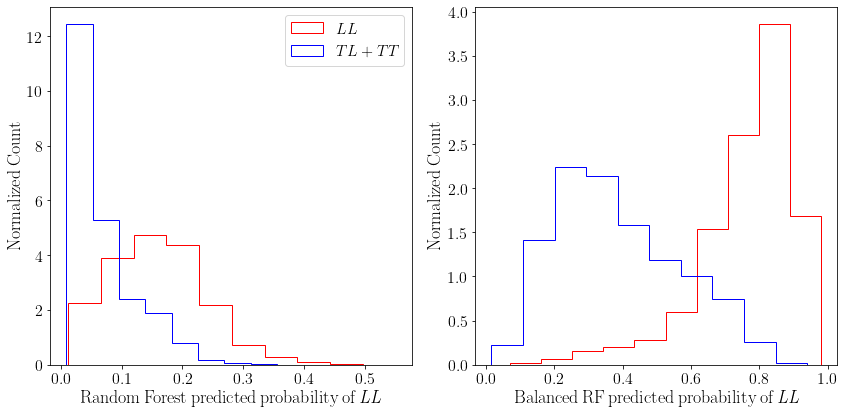

In [45]:
plt.figure(5, figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(clf_rf.predict_proba(X[y == 1]).T[1], 
         bins=10, 
         density=True, 
         color='r', 
         histtype='step', 
         label=r'$LL$')
plt.hist(clf_rf.predict_proba(X[y == 0]).T[1], 
         bins=10, 
         density=True, 
         color='b', 
         histtype='step', 
         label=r'$TL+TT$')
plt.xlabel(r'$\rm Random\, Forest\, predicted\, probability\, of\, \mathit{LL}$')
plt.ylabel(r'$\rm Normalized\, Count$')
plt.legend(loc=1)

plt.subplot(1, 2, 2)
plt.hist(clf_brf.predict_proba(X[y == 1]).T[1], 
         bins=10,  
         density=True, 
         color='r', 
         histtype='step', 
         label=r'$LL$')
plt.hist(clf_brf.predict_proba(X[y == 0]).T[1], 
         bins=10, 
         density=True, 
         color='b', 
         histtype='step', 
         label=r'$TL+TT$')
plt.xlabel(r'$\rm Balanced\, RF\, predicted\, probability\, of\, \mathit{LL}$')
plt.ylabel(r'$\rm Normalized\, Count$')

plt.tight_layout(True)
plt.savefig('/Users/christopherwmurphy/Documents/Research/NNtest/paper/rf_proba.pdf')
plt.show()

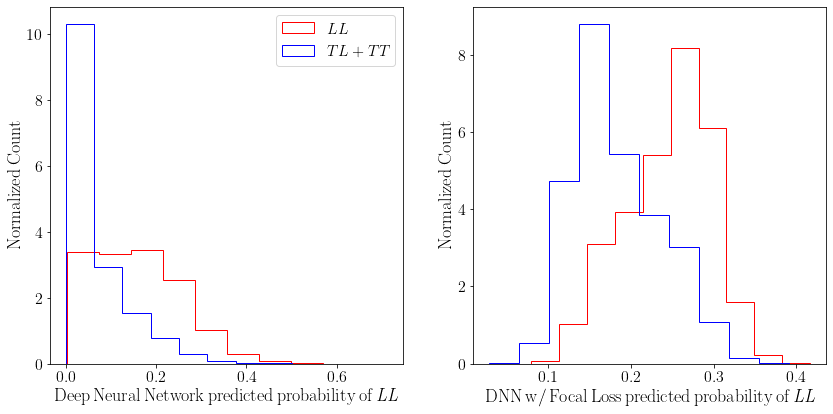

In [46]:
plt.figure(6, figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(clf_dnn.predict_proba(X_dnn[y == 1]), 
         bins=10, 
         density=True, 
         color='r', 
         histtype='step', 
         label=r'$LL$')
plt.hist(clf_dnn.predict_proba(X_dnn[y == 0]), 
         bins=10, 
         density=True, 
         color='b', 
         histtype='step', 
         label=r'$TL+TT$')
plt.xlabel(r'$\rm Deep\, Neural\, Network\, predicted\, probability\, of\, \mathit{LL}$')
plt.ylabel(r'$\rm Normalized\, Count$')
plt.legend(loc=1)

plt.subplot(1, 2, 2)
plt.hist(clf_fl.predict_proba(X_dnn[y == 1]), 
         bins=10,  
         density=True, 
         color='r', 
         histtype='step', 
         label=r'$LL$')
plt.hist(clf_fl.predict_proba(X_dnn[y == 0]), 
         bins=10, 
         density=True, 
         color='b', 
         histtype='step', 
         label=r'$TL+TT$')
plt.xlabel(r'$\rm DNN\, w/\, Focal\, Loss\, predicted\, probability\, of\, \mathit{LL}$')
plt.ylabel(r'$\rm Normalized\, Count$')

plt.tight_layout(True)
plt.savefig('/Users/christopherwmurphy/Documents/Research/NNtest/paper/dnn_proba.pdf')
plt.show()

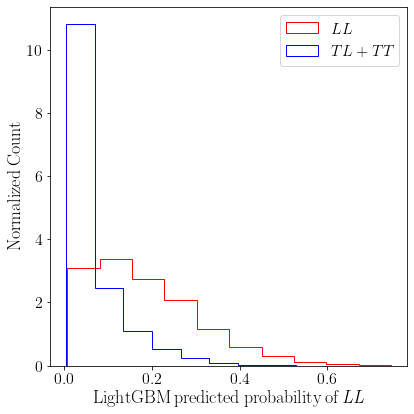

In [47]:
plt.figure(7, figsize=(6, 6))

plt.hist(clf_lgbm.predict_proba(X[y == 1]).T[1], 
         bins=10, 
         density=True, 
         color='r', 
         histtype='step', 
         label=r'$LL$')
plt.hist(clf_lgbm.predict_proba(X[y == 0]).T[1], 
         bins=10, 
         density=True, 
         color='b', 
         histtype='step', 
         label=r'$TL+TT$')
plt.xlabel(r'$\rm LightGBM\, predicted\, probability\, of\, \mathit{LL}$')
plt.ylabel(r'$\rm Normalized\, Count$')
plt.legend(loc=1)

plt.tight_layout(True)
plt.savefig('/Users/christopherwmurphy/Documents/Research/NNtest/paper/lgbm_proba.pdf')
plt.show()

## More Kinematic Distributions

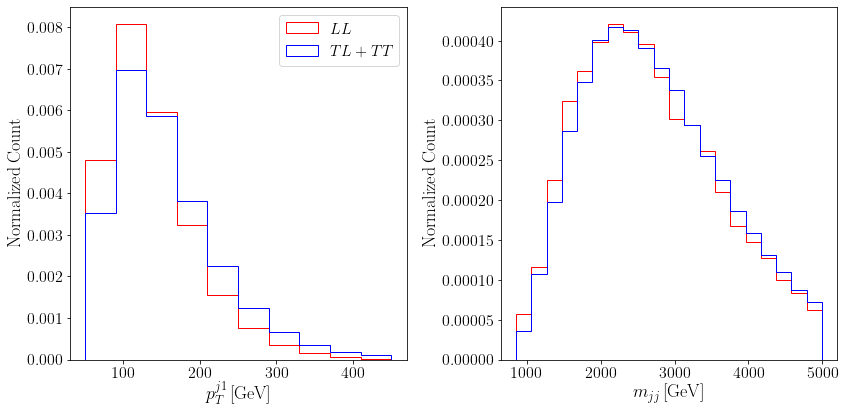

In [55]:
plt.figure(8, figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df[df['has_long_pol'] == 1]['pt.j1'], 
         bins=10, 
         range=(50, 450), 
         density=True, 
         color='r', 
         histtype='step', 
         label=r'$LL$')
plt.hist(df[df['has_long_pol'] == 0]['pt.j1'], 
         bins=10, 
         range=(50, 450), 
         density=True, 
         color='b', 
         histtype='step', 
         label=r'$TL+TT$')
plt.xlabel(r'$p_T^{j 1}\, \rm [GeV]$')
plt.ylabel(r'$\rm Normalized\, Count$')
plt.legend(loc=1)

plt.subplot(1, 2, 2)
plt.hist(df[df['has_long_pol'] == 1]['mm.jj'], 
         bins=20, 
         range=(850, 5000), 
         density=True, 
         color='r', 
         histtype='step', 
         label=r'$LL$')
plt.hist(df[df['has_long_pol'] == 0]['mm.jj'], 
         bins=20, 
         range=(850, 5000), 
         density=True, 
         color='b', 
         histtype='step', 
         label=r'$TL+TT$')
plt.xlabel(r'$m_{jj}\, \rm [GeV]$')
plt.ylabel(r'$\rm Normalized\, Count$')

plt.tight_layout(True)
plt.savefig('/Users/christopherwmurphy/Documents/Research/NNtest/paper/jet_pt.pdf')
plt.show()